In [1]:
# Get city th cities I want to have street view images from

# dictionary with cities

# import osmnx as ox

# use ox.graph_from_place() to get the city street system (Cite Boeing, G. (2025). Modeling and Analyzing Urban Networks and Amenities with OSMnx. Geographical Analysis, published online ahead of print. doi:10.1111/gean.70009)

# build different functions and generate then a pipeline function to use with a .yml file to get a specific dataset

# import utm

# Take four pictures in each direction (N, E, S, W) for each point and classifiy with four pictures. -> take as input four picture
# Or just classify with one picture in the direction of the street (if possible) -> take as input one picture

# From the test dataset tok 1 - all images from a district and then look if the price prediction gets better

# Take a uniform sampled images from the whole city to predict the price of the image labelled with district prices

# Take the same amount of images from every district so identify the district in which you are and then take a random image from this district

# Test both on an other city 

In [2]:
#import utm
import osmnx as ox
import pandas as pd
#import geopandas as gpd
import os
from time import sleep
from random import uniform
import requests
import json
import yaml
import os

In [ ]:
with open('data_config.yml', 'r') as file:
    config = yaml.safe_load(file)

Region_config = config['region']
country = Region_config['country']
city = Region_config['city']
districts = Region_config['districts']

tags = {"boundary": "administrative", "admin_level": "10", "name": districts[11]}
gdf = ox.features_from_place(f"{city}, {country}", tags)

quarter = gdf[gdf["name"] == districts[11]]
polygon = gdf.geometry.iloc[0]

quarter

In [124]:
with open('data_config.yml', 'r') as file:
    config = yaml.safe_load(file)

Region_config = config['region']
country = Region_config['country']
city = Region_config['city']
districts = Region_config['districts']

tags = {"boundary": "administrative"}
gdf = ox.features_from_place(f"{city}, {country}", tags)
gdf[["name", "admin_level"]].drop_duplicates()

name admin_level
element  id                                         
relation 16328             Reinickendorf          10
         16330                   Frohnau          10
         16334             Reinickendorf           9
         16343                   Spandau           9
         16346       Charlottenburg-Nord          10
...                                  ...         ...
         17361789       Lichterfelde Süd          11
         17361790       Lichterfelde Ost          11
         17361791      Lichterfelde West          11
         18326510            Ahrensfelde           9
way      1362358171                  NaN         NaN

[188 rows x 2 columns]

In [5]:
with open('data_config.yml', 'r') as file:
    config = yaml.safe_load(file)

Region_config = config['region']
country = Region_config['country']
city = Region_config['city']
districts = Region_config['districts']

# tags = {"boundary": "administrative", "admin_level": "10", "name": districts[11]}
# gdf = ox.features_from_place(f"{city}, {country}", tags)
# quarter = gdf[gdf.geom_type.isin(['Polygon', 'MultiPolygon'])]

# tags = {"boundary": "administrative", "admin_level": "10"}
# gdf = ox.features_from_place(f"{city}, {country}", tags)
# quarter = gdf
#quarter = gdf[gdf["name"] == districts[22]]

tags = {"boundary": "administrative", "admin_level": "8", "name": "Berlin"}
gdf = ox.features_from_place("Berlin, Germany", tags)
gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])]
#quarter = gdf[gdf["name"] == district]

#print(districts[22])

# tags = {"boundary": "administrative", "admin_level": "10", "name": districts[11]}
# quarter = ox.geocode_to_gdf("Dahlem, Berlin, Germany")

# tags = {"boundary": "administrative", "admin_level": "9"}
# gdf = ox.features_from_place('BE'+ ',' + country, tags)
# quarter = gdf[gdf["name"] == districts[11]]
# quarter = gdf[gdf.geom_type.isin(['Polygon', 'MultiPolygon'])]

if gdf.empty:
    raise ValueError("No polygon geometry found for the selected district!")

# 2. Get street network within Adlershof polygon
berlin_polygon = gdf.geometry.iloc[0]
G = ox.graph_from_polygon(berlin_polygon, network_type="drive")

# 3. Project the graph to UTM
Gp = ox.project_graph(G)

# 4. Make undirected version
Gp_undirected = Gp.to_undirected()

# 5. Sample random points along edges
points = ox.utils_geo.sample_points(Gp_undirected, n=50)

# 6. Extract UTM coordinates
utm_coords = list(zip(points.geometry.x, points.geometry.y))

# 7. Convert back to WGS84 (lat/lon)
points_wgs = points.to_crs(epsg=4326)
latlon_coords = list(zip(points_wgs.geometry.y, points_wgs.geometry.x))

print("UTM coords:", utm_coords)
print("Lat/Lon coords:", latlon_coords)

UTM coords: [(387197.34971389454, 5825220.974053703), (388447.83065037354, 5825100.6054920275), (389526.4959045786, 5824931.270070482), (389166.3355556194, 5824653.179338763), (387667.20994068106, 5825701.491722959), (385541.61833967204, 5825722.434059904), (389044.56370405824, 5825947.434615755), (388340.6796258861, 5825278.114254192), (386363.99931981374, 5824990.620156811), (386388.86771575647, 5825539.102327305), (389552.2453945523, 5825739.641801089), (389711.5190420884, 5825417.252493662), (388488.93339872797, 5824967.053659406), (389723.56068499613, 5825312.899518969), (385763.50769031415, 5825862.073083586), (385882.3052888705, 5825880.492958832), (389535.65526289126, 5825713.046813921), (387813.72159052547, 5825134.394396632), (388464.40453934786, 5825301.451455697), (386078.6562623739, 5824964.891807517), (384902.0224175725, 5825705.140421169), (388575.9237683986, 5826564.971975827), (388438.67212298774, 5826247.753711312), (389287.3292965903, 5825014.563673517), (387936.2799

In [8]:
import osmnx as ox
import yaml
from shapely.ops import unary_union

# 1. Load config
with open('data_config.yml', 'r') as file:
    config = yaml.safe_load(file)

Region_config = config['region']
country = Region_config['country']
city = Region_config['city']
districts = Region_config['districts']

print("Downloading full Berlin road network...")

# Direct way (recommended)
G = ox.graph_from_place(f"{city}, {country}", network_type="drive")

# Project the graph
Gp = ox.project_graph(G)

# Make undirected version
Gp_undirected = Gp.to_undirected()

# Sample random points along edges
points = ox.utils_geo.sample_points(Gp_undirected, n=500)

# Extract UTM coordinates
utm_coords = list(zip(points.geometry.x, points.geometry.y))

# Convert back to WGS84 (lat/lon)
points_wgs = points.to_crs(epsg=4326)
latlon_coords = list(zip(points_wgs.geometry.y, points_wgs.geometry.x))

print("UTM coords:", utm_coords[:5])
print("Lat/Lon coords:", latlon_coords[:5])


UTM coords: [(405670.1395431995, 5818094.334935179), (383229.56650038826, 5818145.451156309), (385964.0276456109, 5831814.39161765), (402139.3255357245, 5806605.573370505), (395752.37549487426, 5820500.1029451415)] ...
Lat/Lon coords: [(52.504805807472685, 13.610219946669503), (52.500921587437816, 13.279727122240427), (52.62433230837471, 13.315291739448243), (52.40092919751943, 13.561586035688764), (52.52462040376623, 13.463399812465932)] ...


In [ ]:
import folium

# Your coordinates
coordinates = latlon_coords

# Calculate center point for the map
center_lat = sum(coord[0] for coord in coordinates) / len(coordinates)
center_lon = sum(coord[1] for coord in coordinates) / len(coordinates)

# Create map centered on the average location
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Add markers for each coordinate
for i, (lat, lon) in enumerate(coordinates):
    folium.Marker(
        [lat, lon],
        popup=f"Point {i+1}: {lat:.6f}, {lon:.6f}",
        tooltip=f"Click for details"
    ).add_to(m)

# Add a line connecting all points
folium.PolyLine(
    locations=[[lat, lon] for lat, lon in coordinates],
    color='blue',
    weight=2,
    opacity=0.7
).add_to(m)

# Save to HTML file
m.save("my_coordinates_map.html")

Map saved as 'my_coordinates_map.html'. Open this file in your browser.


Bounds: 13.5403832, 52.4342297, 13.5422728, 52.4355274
Area size: 0.001890° longitude × 0.001298° latitude


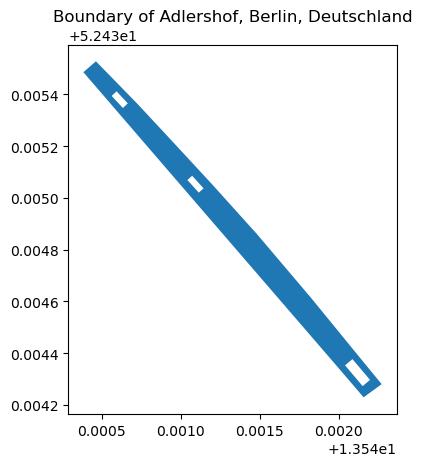

Bounds: 13.4670175, 52.5331188, 13.5322649, 52.5641532
Area size: 0.065247° longitude × 0.031034° latitude


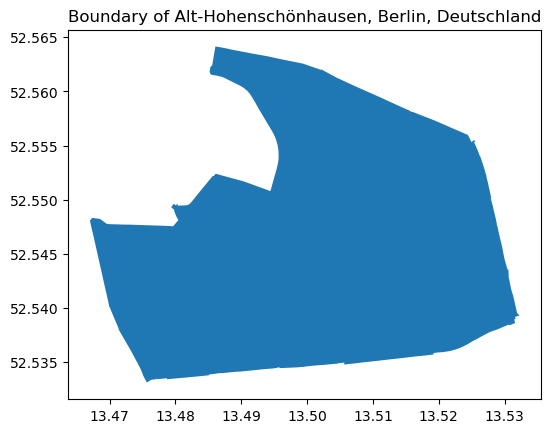

Bounds: 13.4396363, 52.4815331, 13.4829538, 52.4977068
Area size: 0.043318° longitude × 0.016174° latitude


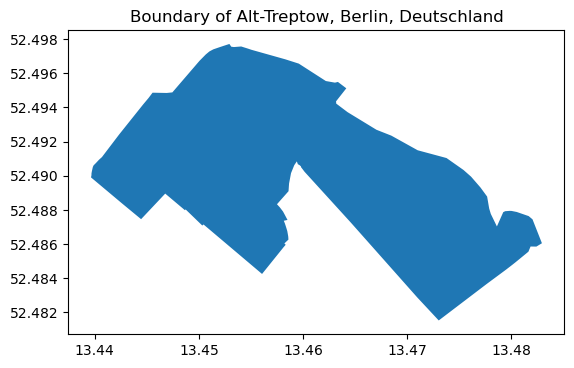

Bounds: 13.516005, 52.3950265, 13.5686742, 52.4262432
Area size: 0.052669° longitude × 0.031217° latitude


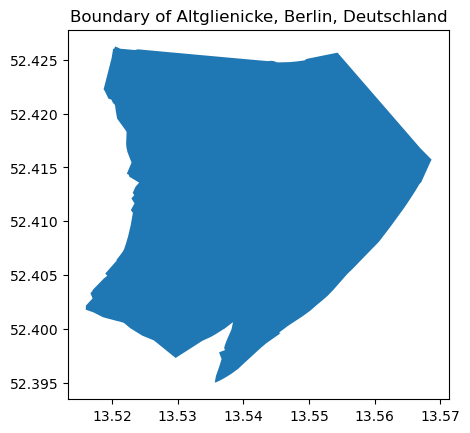

Bounds: 13.4569705, 52.4400502, 13.5005638, 52.4756769
Area size: 0.043593° longitude × 0.035627° latitude


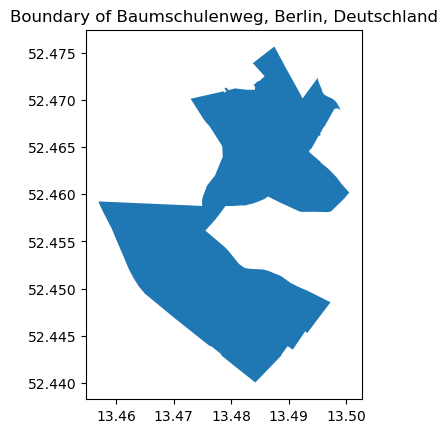

Bounds: 13.5351965, 52.4732052, 13.5846141, 52.5351306
Area size: 0.049418° longitude × 0.061925° latitude


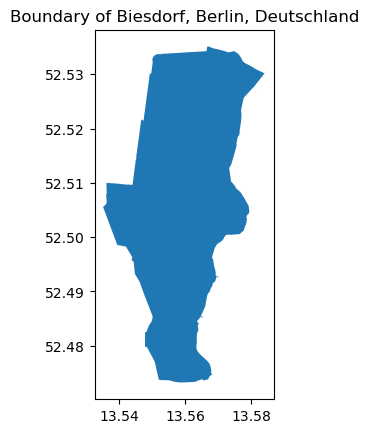

Bounds: 13.4062547, 52.4228864, 13.478685, 52.465155
Area size: 0.072430° longitude × 0.042269° latitude


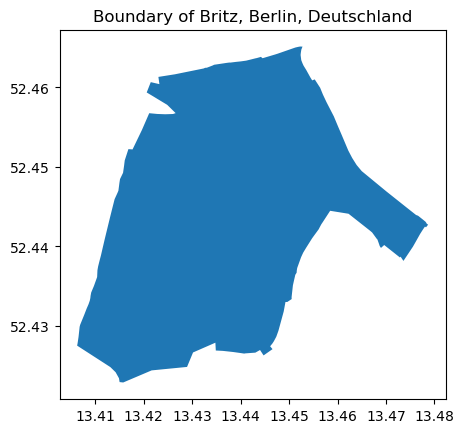

Bounds: 13.4200259, 52.6195619, 13.523022, 52.6755087
Area size: 0.102996° longitude × 0.055947° latitude


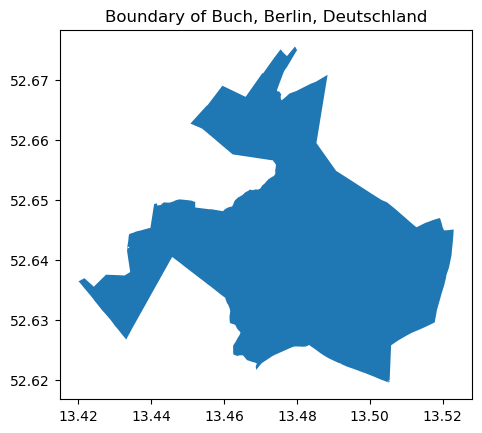

Bounds: 13.3994933, 52.4101838, 13.4794152, 52.4444845
Area size: 0.079922° longitude × 0.034301° latitude


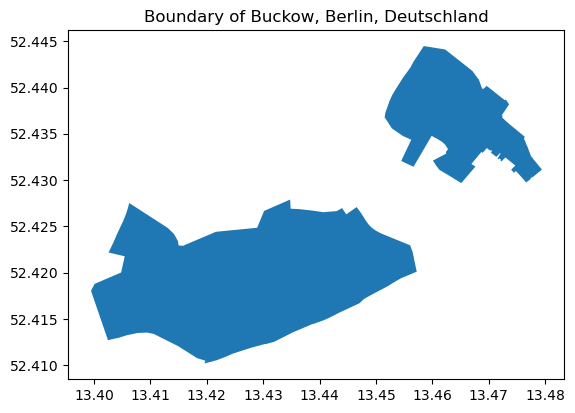

Bounds: 13.2806236, 52.4990215, 13.3414287, 52.5323723
Area size: 0.060805° longitude × 0.033351° latitude


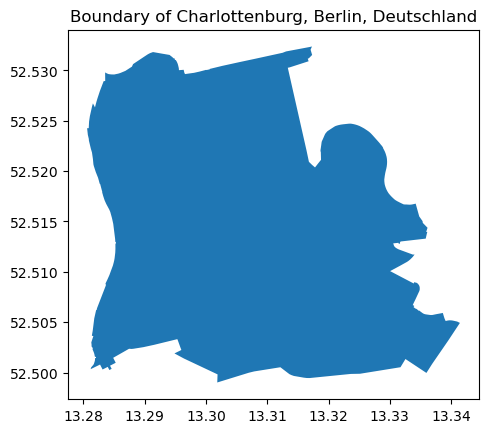

Bounds: 13.2699758, 52.5295918, 13.3291366, 52.5494336
Area size: 0.059161° longitude × 0.019842° latitude


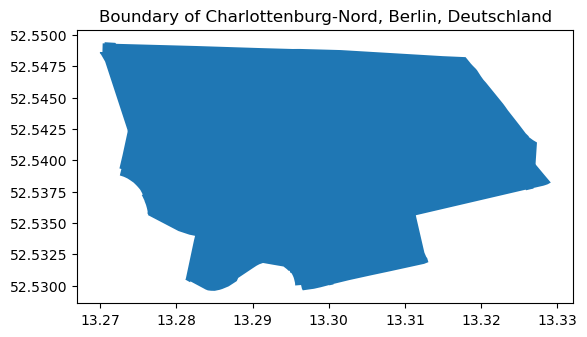

Bounds: 13.2614629, 52.4540828, 13.2661749, 52.4570354
Area size: 0.004712° longitude × 0.002953° latitude


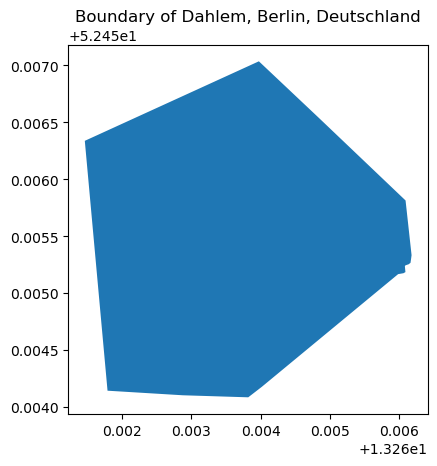

Bounds: 13.1434816, 52.5372385, 13.195617, 52.5677149
Area size: 0.052135° longitude × 0.030476° latitude


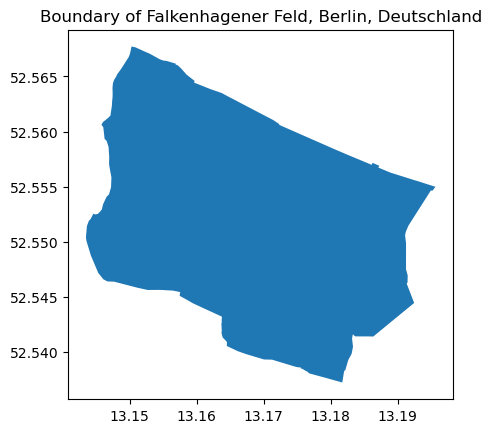

Bounds: 13.4561965, 52.522809, 13.4854115, 52.5404583
Area size: 0.029215° longitude × 0.017649° latitude


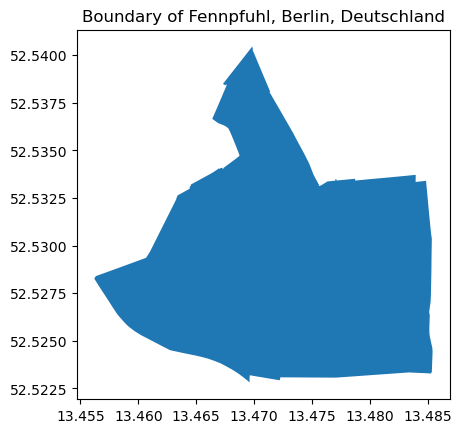

Bounds: 13.4119724, 52.5821477, 13.4689596, 52.6404185
Area size: 0.056987° longitude × 0.058271° latitude


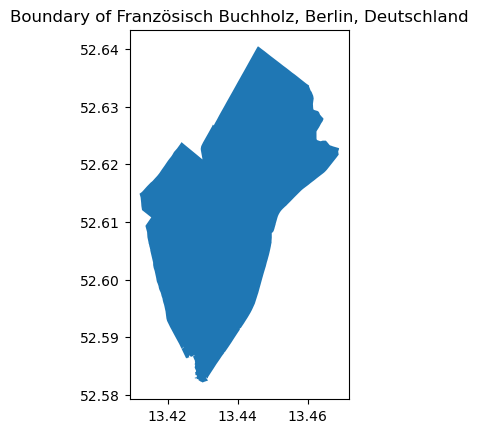

Bounds: 13.3199923, 52.464473, 13.3438697, 52.4785899
Area size: 0.023877° longitude × 0.014117° latitude


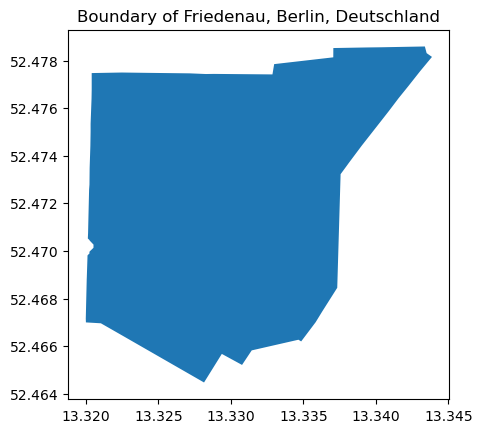

Bounds: 13.5088154, 52.5145879, 13.5192021, 52.523641
Area size: 0.010387° longitude × 0.009053° latitude


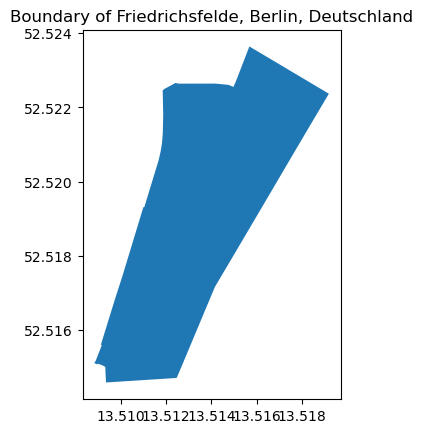

Bounds: 13.5942679, 52.4374223, 13.669468, 52.4792245
Area size: 0.075200° longitude × 0.041802° latitude


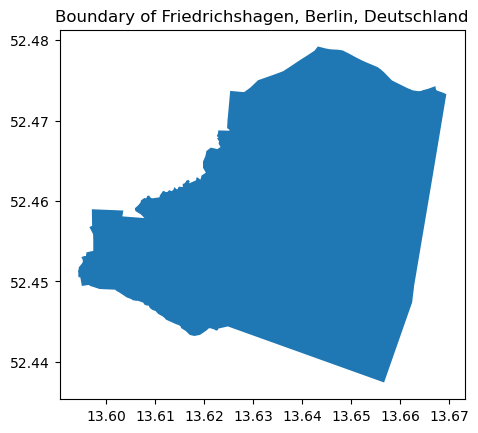

Bounds: 13.3682291, 52.4827923, 13.4914434, 52.5310256
Area size: 0.123214° longitude × 0.048233° latitude


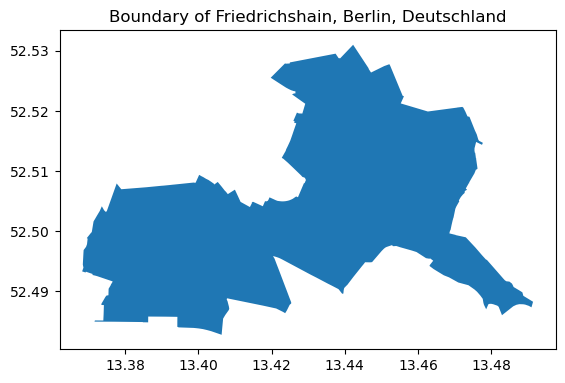

Bounds: 13.2621503, 52.6247703, 13.3102758, 52.6607411
Area size: 0.048125° longitude × 0.035971° latitude


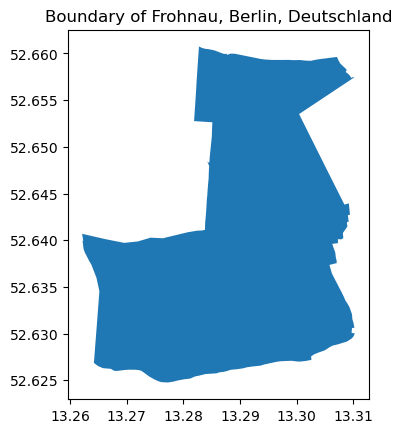

Bounds: 13.365896, 52.5331793, 13.4035279, 52.5676686
Area size: 0.037632° longitude × 0.034489° latitude


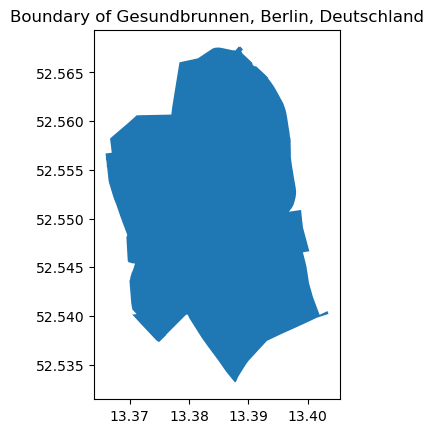

Bounds: 13.4460858, 52.4195412, 13.4852716, 52.4366965
Area size: 0.039186° longitude × 0.017155° latitude


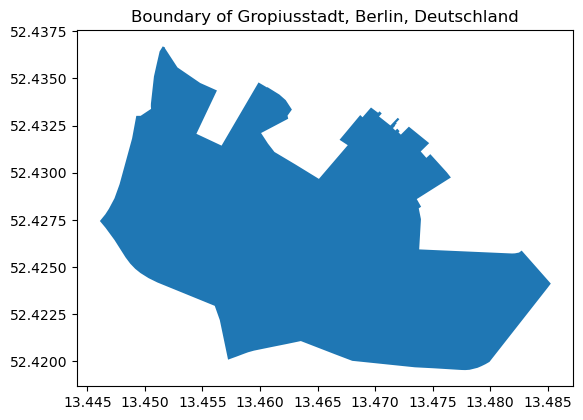

Bounds: 13.1767252, 52.4325129, 13.2780813, 52.5092138
Area size: 0.101356° longitude × 0.076701° latitude


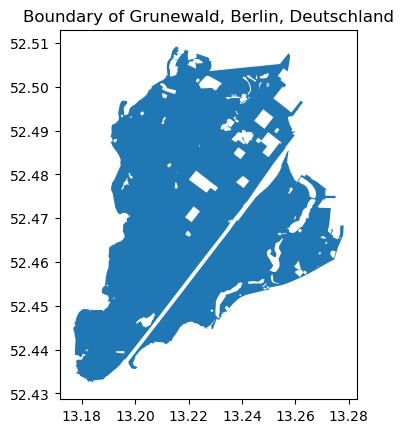

Bounds: 13.5543099, 52.3790999, 13.6326147, 52.4283846
Area size: 0.078305° longitude × 0.049285° latitude


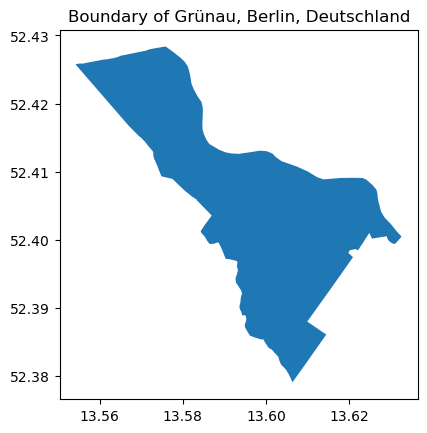

Bounds: 13.1279616, 52.5435654, 13.2287231, 52.5987969
Area size: 0.100761° longitude × 0.055232° latitude


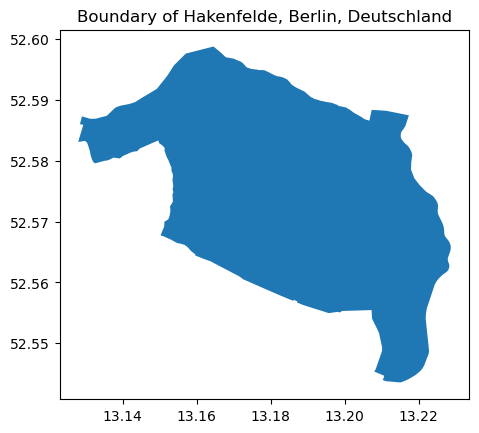

Bounds: 13.2765026, 52.491973, 13.2827837, 52.4960362
Area size: 0.006281° longitude × 0.004063° latitude


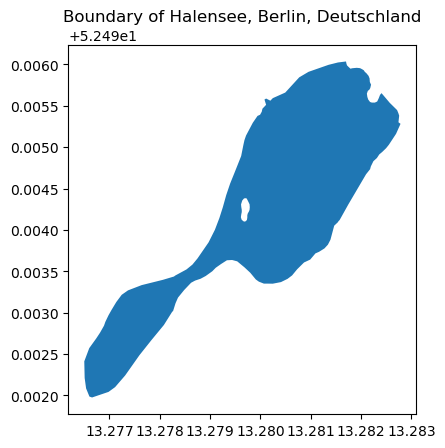

Bounds: 13.210181, 52.6004648, 13.2197263, 52.6087237
Area size: 0.009545° longitude × 0.008259° latitude


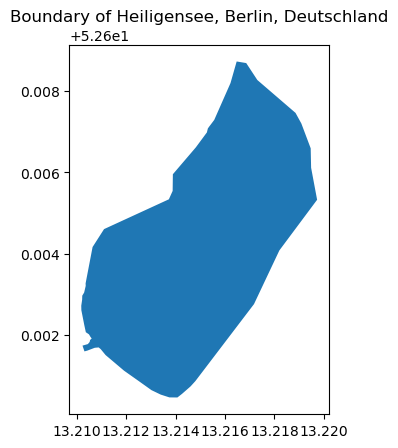

Bounds: 13.4272141, 52.556651, 13.4583109, 52.5829481
Area size: 0.031097° longitude × 0.026297° latitude


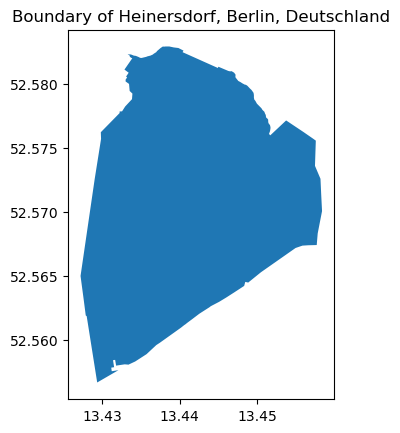

Bounds: 13.5168837, 52.4704746, 13.6585034, 52.5745093
Area size: 0.141620° longitude × 0.104035° latitude


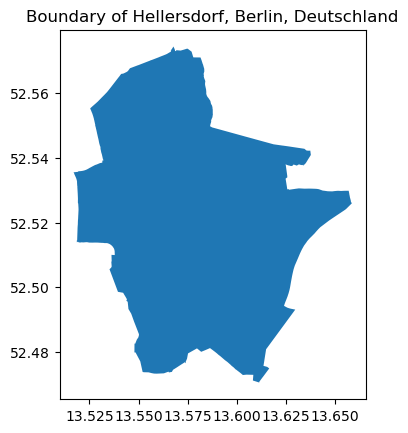

Bounds: 13.4755239, 52.4267279, 13.5324234, 52.4601826
Area size: 0.056900° longitude × 0.033455° latitude


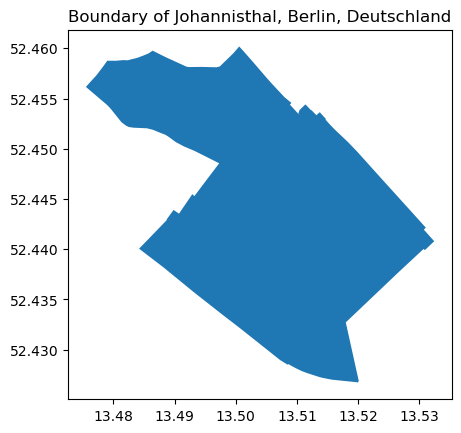

Bounds: 13.5015441, 52.4678355, 13.5525971, 52.4982942
Area size: 0.051053° longitude × 0.030459° latitude


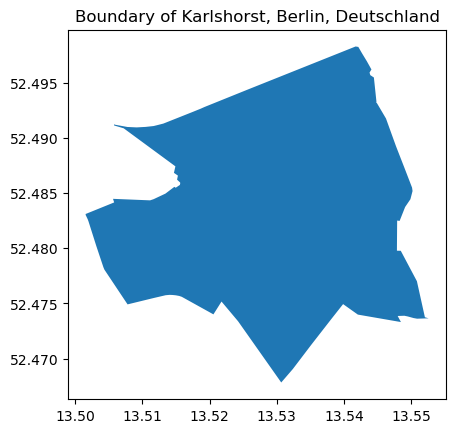

Bounds: 13.4529475, 52.5984866, 13.5050644, 52.6258656
Area size: 0.052117° longitude × 0.027379° latitude


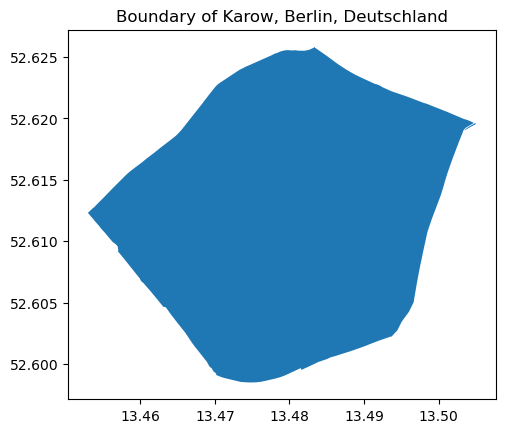

Bounds: 13.5634409, 52.4746775, 13.6219716, 52.5289749
Area size: 0.058531° longitude × 0.054297° latitude


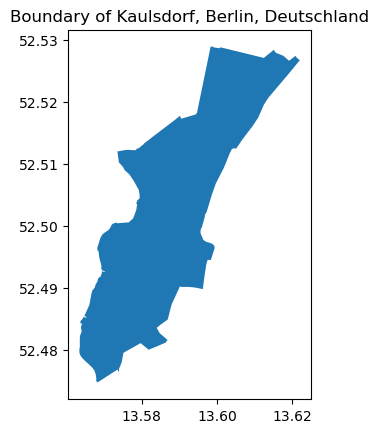

Bounds: 13.3682291, 52.4827923, 13.4914434, 52.5310256
Area size: 0.123214° longitude × 0.048233° latitude


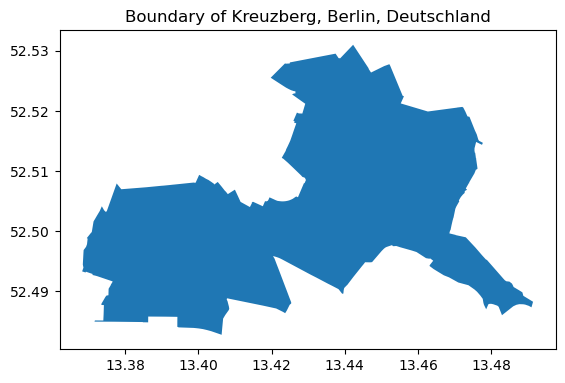

Bounds: 13.4396363, 52.3382448, 13.7611609, 52.4977068
Area size: 0.321525° longitude × 0.159462° latitude


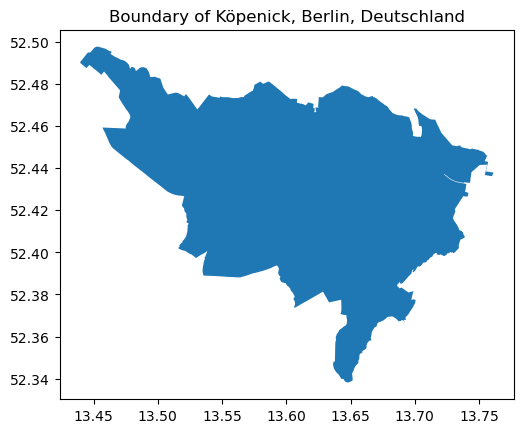

Bounds: 13.3272242, 52.4151944, 13.37157, 52.4456057
Area size: 0.044346° longitude × 0.030411° latitude


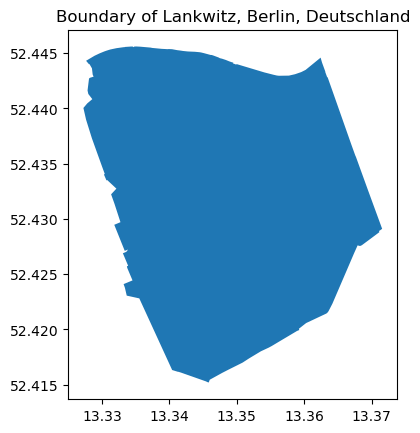

Bounds: 13.4561965, 52.4678355, 13.5677043, 52.5964629
Area size: 0.111508° longitude × 0.128627° latitude


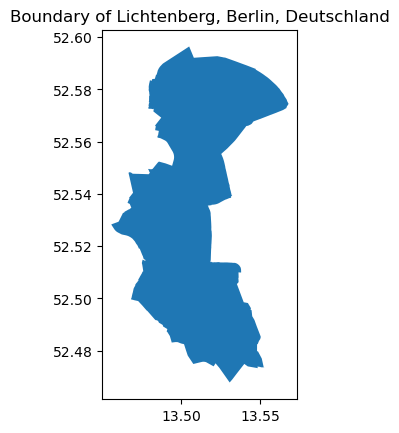

Bounds: 13.3799426, 52.3761384, 13.42746, 52.418132
Area size: 0.047517° longitude × 0.041994° latitude


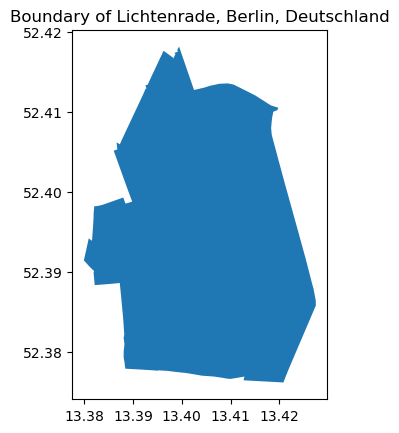

Bounds: 13.2956752, 52.4292393, 13.3031983, 52.4323633
Area size: 0.007523° longitude × 0.003124° latitude


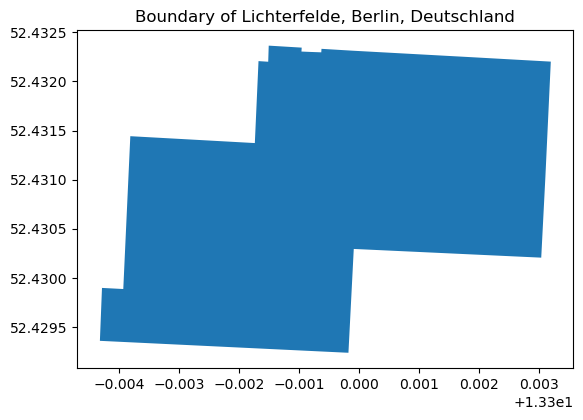

Bounds: 13.5839659, 52.4704746, 13.6585034, 52.5305734
Area size: 0.074537° longitude × 0.060099° latitude


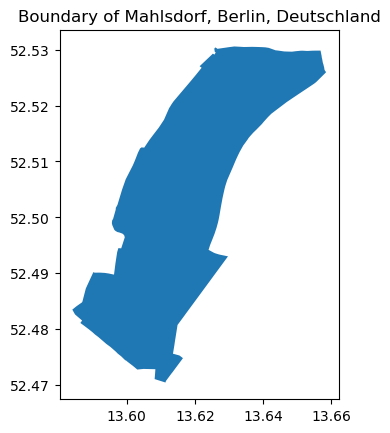

Bounds: 13.3864391, 52.4403359, 13.3990408, 52.4446625
Area size: 0.012602° longitude × 0.004327° latitude


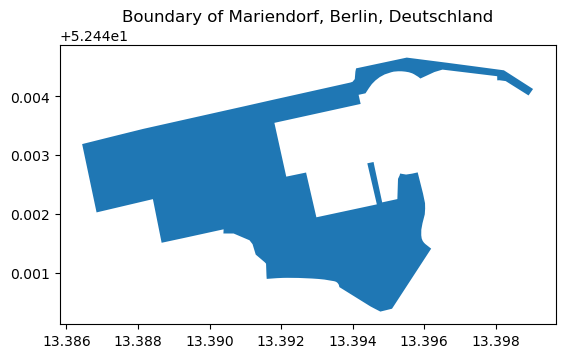

Bounds: 13.3427431, 52.3881457, 13.3963048, 52.4291927
Area size: 0.053562° longitude × 0.041047° latitude


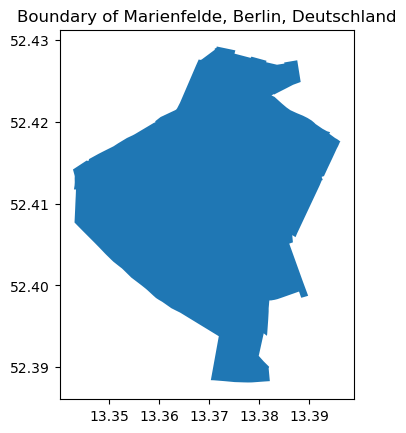

Bounds: 13.5168837, 52.4704746, 13.6585034, 52.5745093
Area size: 0.141620° longitude × 0.104035° latitude


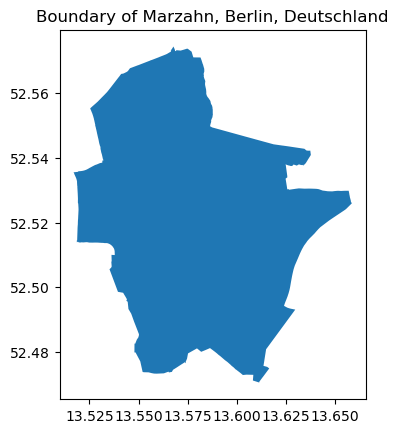

Bounds: 13.3015376, 52.4987207, 13.4294017, 52.5676686
Area size: 0.127864° longitude × 0.068948° latitude


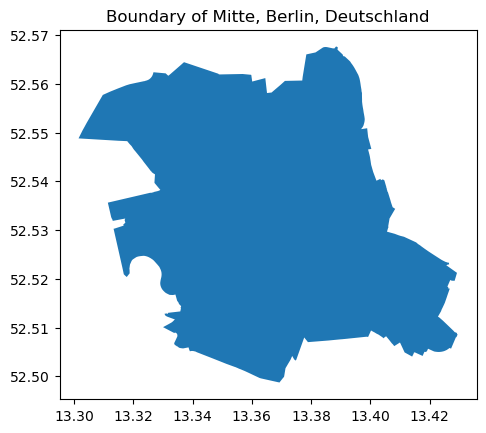

Bounds: 13.3459248, 52.5263955, 13.3492291, 52.5305982
Area size: 0.003304° longitude × 0.004203° latitude


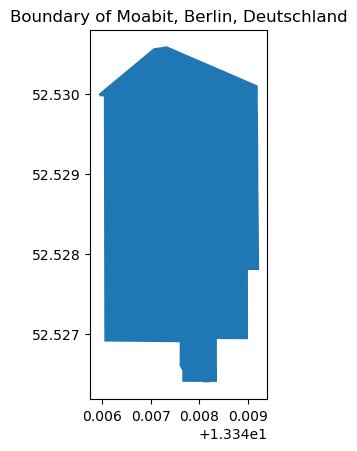

Bounds: 13.4835902, 52.5553141, 13.5419, 52.57907
Area size: 0.058310° longitude × 0.023756° latitude


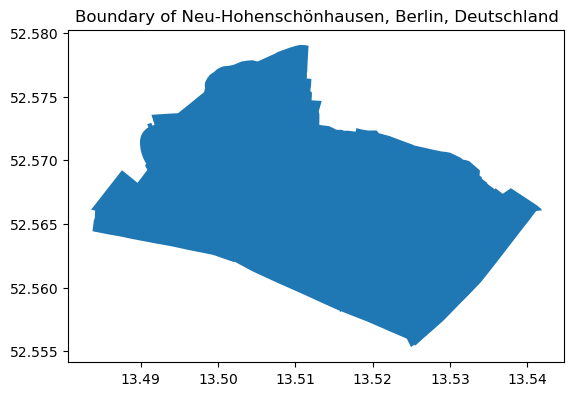

Bounds: 13.3994933, 52.3959454, 13.5241327, 52.495865
Area size: 0.124639° longitude × 0.099920° latitude


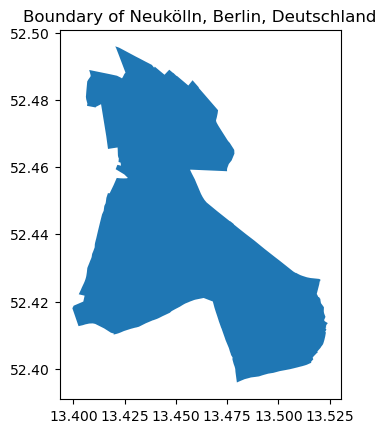

Bounds: 13.4935702, 52.4421354, 13.5585102, 52.4691128
Area size: 0.064940° longitude × 0.026977° latitude


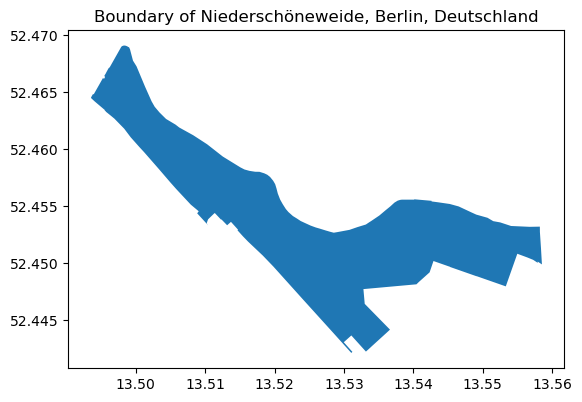

Bounds: 13.3661967, 52.5682425, 13.4283685, 52.5945855
Area size: 0.062172° longitude × 0.026343° latitude


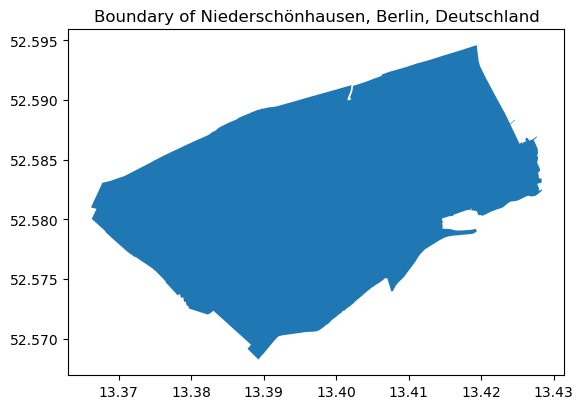

Bounds: 13.1894722, 52.4224499, 13.1947958, 52.4258157
Area size: 0.005324° longitude × 0.003366° latitude


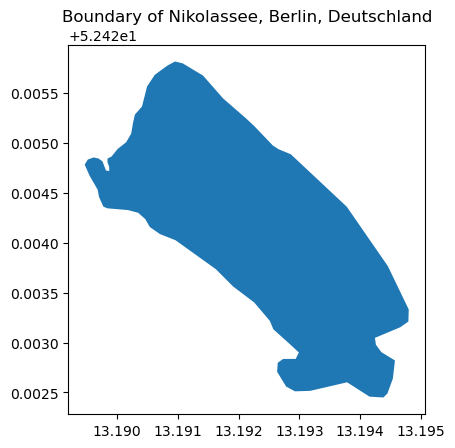

Bounds: 13.5295316, 52.4625714, 13.5345103, 52.4653427
Area size: 0.004979° longitude × 0.002771° latitude


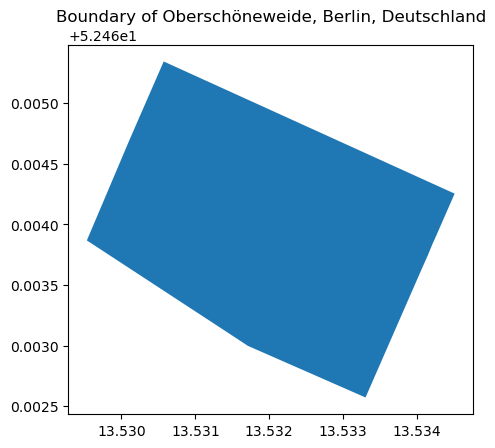

Bounds: 13.3475571, 52.5199276, 13.523022, 52.6755087
Area size: 0.175465° longitude × 0.155581° latitude


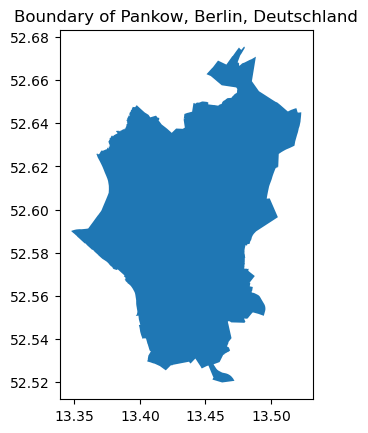

Bounds: 13.396846, 52.5199276, 13.4721073, 52.5585856
Area size: 0.075261° longitude × 0.038658° latitude


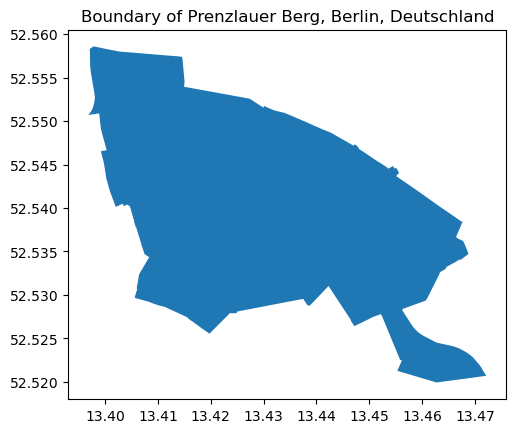

Bounds: 13.656757, 52.416337, 13.7611609, 52.4732841
Area size: 0.104404° longitude × 0.056947° latitude


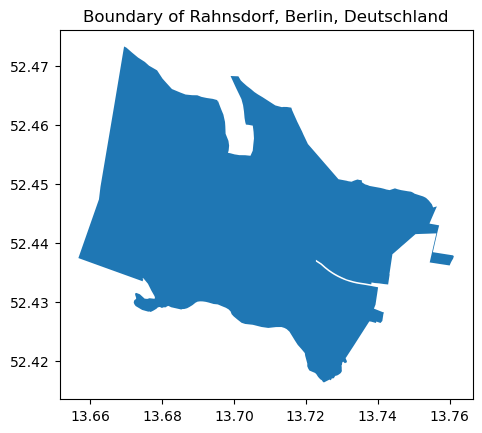

Bounds: 13.2016176, 52.5488072, 13.3892817, 52.6607411
Area size: 0.187664° longitude × 0.111934° latitude


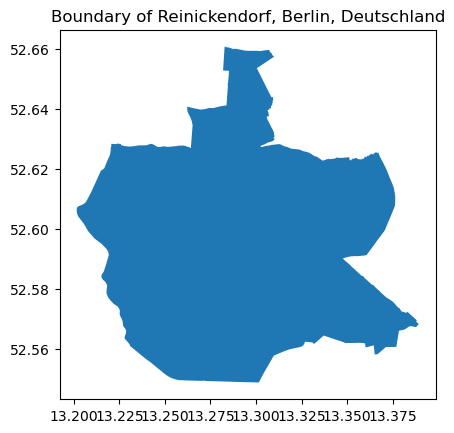

Bounds: 13.4680167, 52.3959454, 13.5241327, 52.4427362
Area size: 0.056116° longitude × 0.046791° latitude


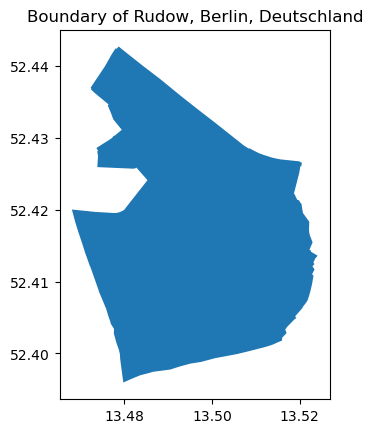

Bounds: 13.4685734, 52.4824494, 13.5156207, 52.514461
Area size: 0.047047° longitude × 0.032012° latitude


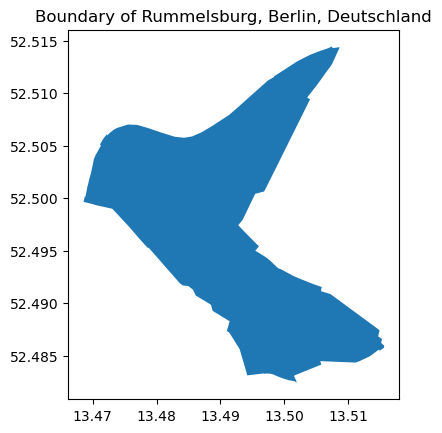

Bounds: 13.2905106, 52.4728843, 13.2940267, 52.4744137
Area size: 0.003516° longitude × 0.001529° latitude


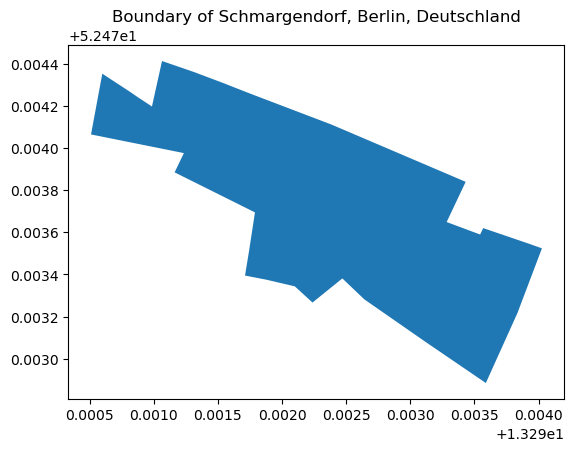

Bounds: 13.6054691, 52.3382448, 13.7098516, 52.4010105
Area size: 0.104382° longitude × 0.062766° latitude


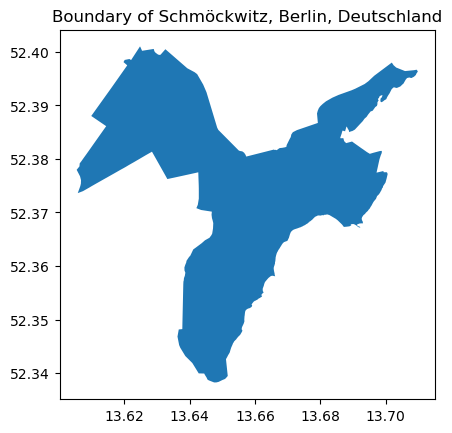

Bounds: 13.3199923, 52.3761384, 13.42746, 52.5049347
Area size: 0.107468° longitude × 0.128796° latitude


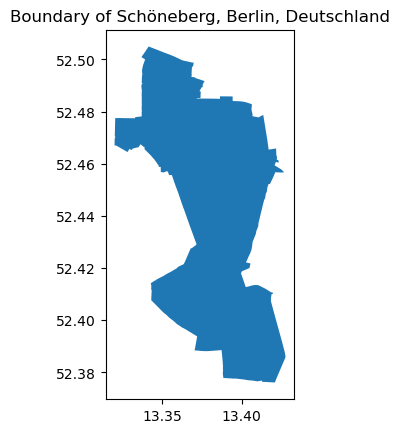

Bounds: 13.2316701, 52.5271793, 13.2824665, 52.5571787
Area size: 0.050796° longitude × 0.029999° latitude


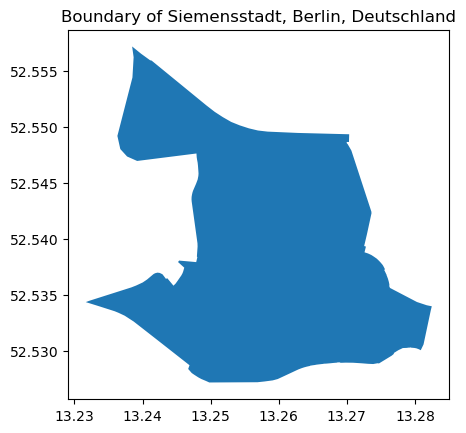

Bounds: 13.109295, 52.439615, 13.2824665, 52.5987969
Area size: 0.173172° longitude × 0.159182° latitude


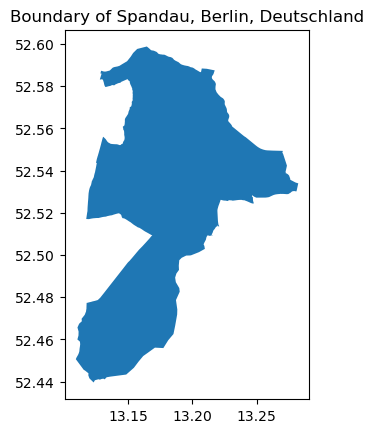

Bounds: 13.1173799, 52.5129381, 13.1757955, 52.5560119
Area size: 0.058416° longitude × 0.043074° latitude


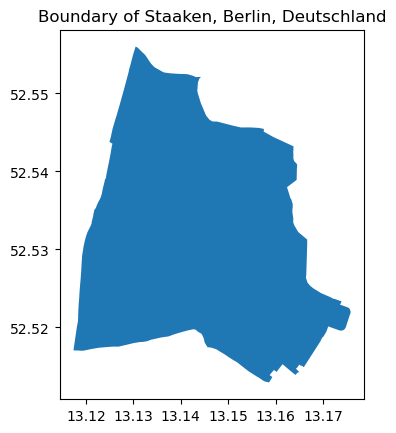

Bounds: 13.3391369, 52.4536878, 13.3466685, 52.4589409
Area size: 0.007532° longitude × 0.005253° latitude


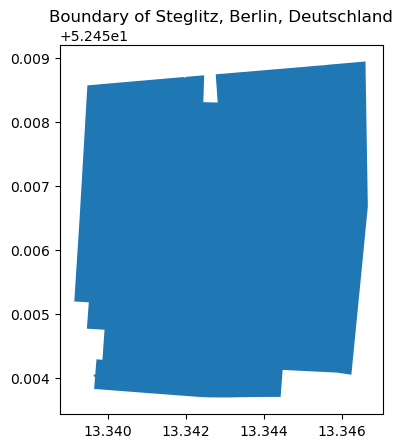

Bounds: 13.2205826, 52.5488072, 13.3215379, 52.626129
Area size: 0.100955° longitude × 0.077322° latitude


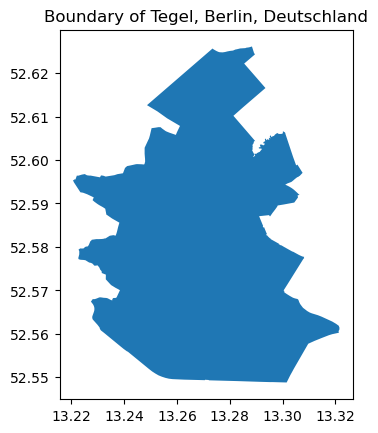

Bounds: 13.3199923, 52.3761384, 13.42746, 52.5049347
Area size: 0.107468° longitude × 0.128796° latitude


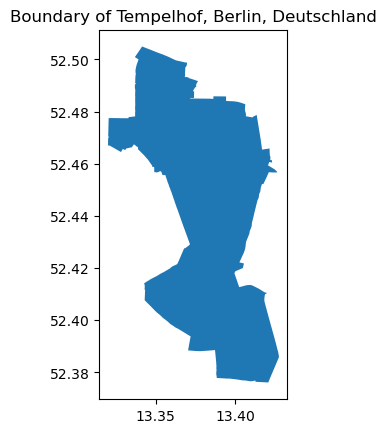

Bounds: 13.3300432, 52.4987207, 13.3776503, 52.5228053
Area size: 0.047607° longitude × 0.024085° latitude


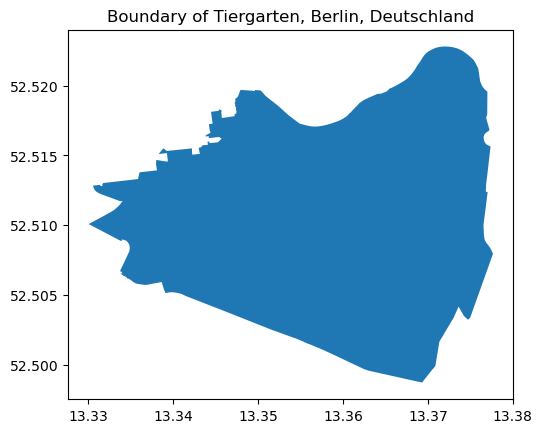

Bounds: 13.088345, 52.3872254, 13.1869132, 52.4521973
Area size: 0.098568° longitude × 0.064972° latitude


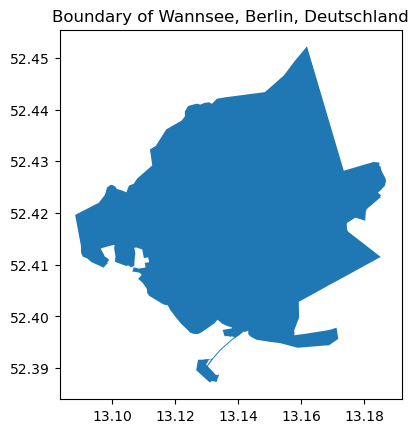

Bounds: 13.3644034, 52.542734, 13.3656118, 52.5434251
Area size: 0.001208° longitude × 0.000691° latitude


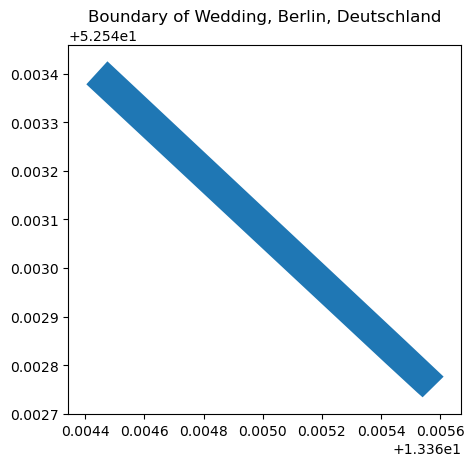

Bounds: 13.4550624, 52.538498, 13.4698337, 52.5456046
Area size: 0.014771° longitude × 0.007107° latitude


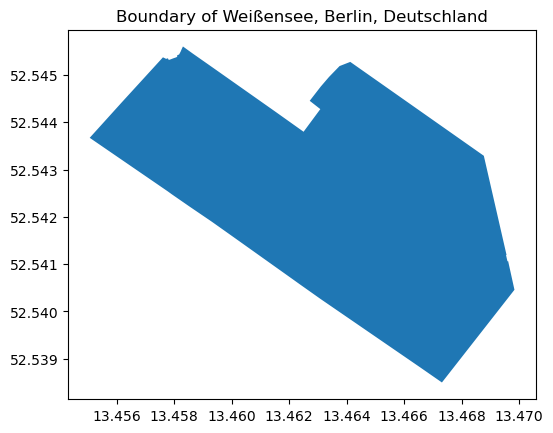

Bounds: 13.2087621, 52.4889234, 13.2853279, 52.5304889
Area size: 0.076566° longitude × 0.041566° latitude


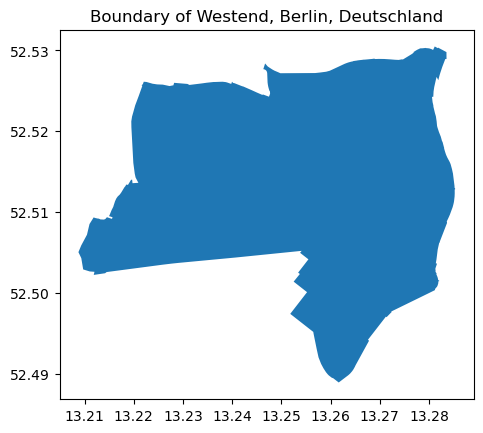

Bounds: 13.157237, 52.4986912, 13.2226524, 52.5309207
Area size: 0.065415° longitude × 0.032229° latitude


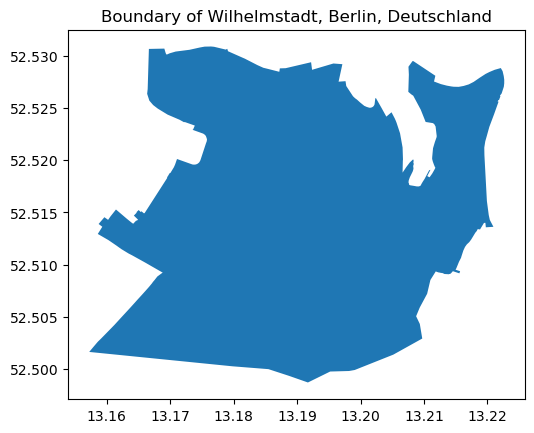

Bounds: 13.3086482, 52.4841055, 13.3136253, 52.4874239
Area size: 0.004977° longitude × 0.003318° latitude


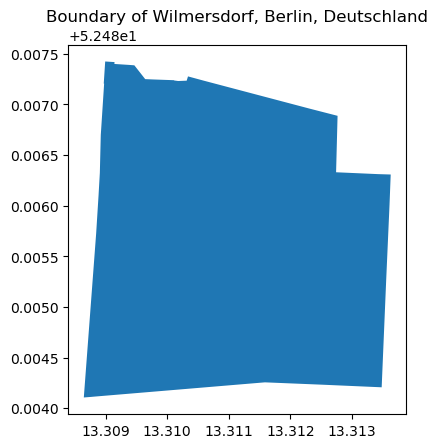

Bounds: 13.3009942, 52.5777795, 13.3474764, 52.6084617
Area size: 0.046482° longitude × 0.030682° latitude


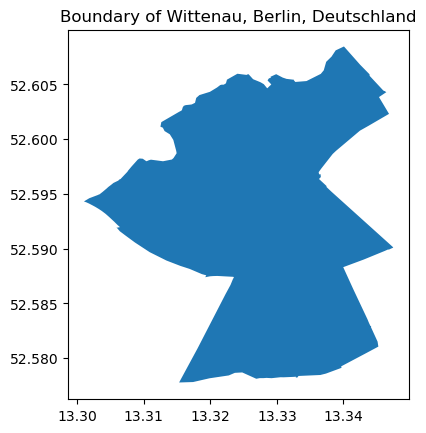

TypeError: Nominatim did not geocode query 'Zehlendorf, Berlin, Deutschland' to a geometry of type (Multi)Polygon.

In [11]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

for district in districts:

    quarter = district + ", " + city + ", " + country

    # Get the polygon boundary of the area
    area_gdf = ox.geocode_to_gdf(quarter)
    polygon = area_gdf.geometry.iloc[0]

    # Check the bounds
    minx, miny, maxx, maxy = polygon.bounds
    print(f"Bounds: {minx}, {miny}, {maxx}, {maxy}")
    print(f"Area size: {(maxx-minx):.6f}° longitude × {(maxy-miny):.6f}° latitude")

    # Visualize the polygon
    ax = area_gdf.plot()
    ax.set_title(f"Boundary of {quarter}")
    plt.show()

In [9]:
import geopandas as gpd
from shapely.geometry import Point
import random

def generate_random_points_in_polygon(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    
    while len(points) < num_points:
        # Generate random point within bounding box
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        
        # Check if point is within the actual polygon
        if polygon.contains(random_point):
            points.append(random_point)
    
    return points

# Get the polygon boundary
area = ox.geocode_to_gdf(quarter)
polygon = area.geometry.iloc[0]

# Generate points
points = generate_random_points_in_polygon(polygon, 10)

# Convert to GeoDataFrame and get coordinates
points_gdf = gpd.GeoDataFrame(geometry=points, crs=4326)
latlon_coords = list(zip(points_gdf.geometry.y, points_gdf.geometry.x))

In [10]:
latlon_coords

[(52.43541530416652, 13.540633356496603),
 (52.434745393648235, 13.541430390861628),
 (52.4343141106592, 13.542050690554616),
 (52.43489939166229, 13.541392527612828),
 (52.43537103422881, 13.540553294017574),
 (52.435416348513925, 13.540599637570311),
 (52.434414256167805, 13.541932141726324),
 (52.43533898813346, 13.540697435588603),
 (52.43435016154364, 13.54202963309693),
 (52.434427301297255, 13.542075039600526)]

In [ ]:
city = "Paris"
town = city + ", France"
G = ox.graph_from_place(town)

In [7]:
Gp = ox.project_graph(G)
Gp_undirected = Gp.to_undirected()
points = ox.utils_geo.sample_points(Gp_undirected, 10)

In [8]:
utm_coords = list(zip(points.geometry.x, points.geometry.y))
utm_coords[0][1]

5412147.432928762

In [9]:
crs = Gp.graph['crs']
points.crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
points_wgs = points.to_crs(epsg=4326) # EPSG:4326 is standard coord reference system for lat and lon
latlon_coords = list(zip(points_wgs.geometry.y, points_wgs.geometry.x))

In [25]:
df = pd.DataFrame(latlon_coords, columns=['latitude', 'longitude'])
df.to_csv('paris_points.csv', index=False)

In [26]:
API_KEY = input("Bitte Google API Key eingeben:")
url = 'https://maps.googleapis.com/maps/api/streetview?'
meta_url = 'https://maps.googleapis.com/maps/api/streetview/metadata?'

In [33]:
latlon_coords[:5]

[(48.86032977936859, 2.327612178026431),
 (48.86993793658035, 2.3424412915780906),
 (48.852874595242696, 2.3004957756660787),
 (48.82570886607523, 2.3656341006138213),
 (48.85286697488344, 2.307204343016168)]

In [34]:
from random import uniform
max_retries = 5

for coord in latlon_coords[:5]:
    lat = coord[0]
    lon = coord[1]

    for heading_degrees in [0, 90, 180, 270]:
        heading_letter = 'NESW'[heading_degrees // 90] 
        params = {
                    'size': '640x640',
                    'location': str(lat) + ',' + str(lon),
                    'heading': str(heading_degrees),
                    'pitch': '20',
                    'key': API_KEY
                }
        
        meta_params = {
                    'key': API_KEY,
                    'location': str(lat) + ',' + str(lon)
                }
        
        attempts = 0
        success = False

        while attempts < max_retries and not success:

            attempts += 1

            try:
                meta_response = requests.get(meta_url, params=meta_params).json()
                status = meta_response.get('status')

                if status == 'REQUEST_DENIED':
                    #sleep(uniform(0.75,1.5)) # To avoid hitting API rate limits
                    continue

                elif status == 'OK':
                    response = requests.get(url, params)
                    response.raise_for_status() # # Raise exception for HTTP errors
                    image_filename = os.path.join("Images", "Paris", f'{heading_letter}_{lat},{lon}.jpg')

                    with open(image_filename, "wb") as file:
                                file.write(response.content)
                    
                    success = True
                    #sleep(uniform(0.75,1.5))
                
                else:
                    # Handle other statuses like 'ZERO_RESULTS', 'OVER_QUERY_LIMIT', 'UNKNOWN_ERROR'
                    print(f"Attempt {attempts} failed with status: {status}. Retrying...")
                    #sleep(uniform(0.75,1.5))


            except requests.exceptions.RequestException as e:
                    print(f"Attempt {attempts} failed with network error: {e}. Retrying...")
                    #sleep(uniform(0.75,1.5))

        if not success:
                    print(f"Failed to get image for {x},{y} after {max_retries} attempts. Moving on.")

In [17]:
import geopandas as gpd

geojson_path = "lor_ortsteile.geojson"
gdf = gpd.read_file(geojson_path)
quarters = sorted(gdf['OTEIL'].unique())
for q in quarters:
    print(q)

Adlershof
Alt-Hohenschönhausen
Alt-Treptow
Altglienicke
Baumschulenweg
Biesdorf
Blankenburg
Blankenfelde
Bohnsdorf
Borsigwalde
Britz
Buch
Buckow
Charlottenburg
Charlottenburg-Nord
Dahlem
Falkenberg
Falkenhagener Feld
Fennpfuhl
Französisch Buchholz
Friedenau
Friedrichsfelde
Friedrichshagen
Friedrichshain
Frohnau
Gatow
Gesundbrunnen
Gropiusstadt
Grunewald
Grünau
Hakenfelde
Halensee
Hansaviertel
Haselhorst
Heiligensee
Heinersdorf
Hellersdorf
Hermsdorf
Johannisthal
Karlshorst
Karow
Kaulsdorf
Kladow
Konradshöhe
Kreuzberg
Köpenick
Lankwitz
Lichtenberg
Lichtenrade
Lichterfelde
Lübars
Mahlsdorf
Malchow
Mariendorf
Marienfelde
Marzahn
Mitte
Moabit
Märkisches Viertel
Müggelheim
Neu-Hohenschönhausen
Neukölln
Niederschöneweide
Niederschönhausen
Nikolassee
Oberschöneweide
Pankow
Plänterwald
Prenzlauer Berg
Rahnsdorf
Reinickendorf
Rosenthal
Rudow
Rummelsburg
Schmargendorf
Schmöckwitz
Schöneberg
Siemensstadt
Spandau
Staaken
Stadtrandsiedlung Malchow
Steglitz
Tegel
Tempelhof
Tiergarten
Waidmannslust
Wa

In [4]:
import geopandas as gpd
import osmnx as ox

# Read the GeoJSON file
gdf = gpd.read_file('lor_ortsteile.geojson')

# Check the structure of your data
print(gdf.head())
print(gdf.crs)  # Check coordinate reference system

if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

polygon = gdf.geometry.iloc[0]
G = ox.graph_from_polygon(polygon, network_type="drive")

             gml_id spatial_name spatial_alias spatial_type         OTEIL  \
0  re_ortsteil.0101         0101         Mitte      Polygon         Mitte   
1  re_ortsteil.0102         0102        Moabit      Polygon        Moabit   
2  re_ortsteil.0103         0103  Hansaviertel      Polygon  Hansaviertel   
3  re_ortsteil.0104         0104    Tiergarten      Polygon    Tiergarten   
4  re_ortsteil.0105         0105       Wedding      Polygon       Wedding   

  BEZIRK  FLAECHE_HA                                           geometry  
0  Mitte   1063.8748  POLYGON ((13.41649 52.52696, 13.41635 52.52702...  
1  Mitte    768.7909  POLYGON ((13.33884 52.51974, 13.33884 52.51974...  
2  Mitte     52.5337  POLYGON ((13.34322 52.51557, 13.34323 52.51557...  
3  Mitte    516.0672  POLYGON ((13.36879 52.49878, 13.36891 52.49877...  
4  Mitte    919.9112  POLYGON ((13.34656 52.53879, 13.34664 52.53878...  
EPSG:4326


In [ ]:
import geopandas as gpd
import osmnx as ox
from shapely.ops import unary_union

with open('data_config.yml', 'r') as file:
    config = yaml.safe_load(file)

Region_config = config['region']
country = Region_config['country']
city = Region_config['city']
districts = Region_config['districts']

gdf = gpd.read_file('lor_ortsteile.geojson')
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

combined_polygon = unary_union(gdf.geometry)

print(combined_polygon)

G = ox.graph_from_polygon(combined_polygon, network_type="drive")

Gp = ox.project_graph(G)

Gp_undirected = Gp.to_undirected()

points = ox.utils_geo.sample_points(Gp_undirected, n=50)

utm_coords = list(zip(points.geometry.x, points.geometry.y))

points_wgs = points.to_crs(epsg=4326)
latlon_coords = list(zip(points_wgs.geometry.y, points_wgs.geometry.x))

print("UTM coords:", utm_coords)
print("Lat/Lon coords:", latlon_coords)

import folium

# Your coordinates
coordinates = latlon_coords

# Calculate center point for the map
center_lat = sum(coord[0] for coord in coordinates) / len(coordinates)
center_lon = sum(coord[1] for coord in coordinates) / len(coordinates)

# Create map centered on the average location
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Add markers for each coordinate
for i, (lat, lon) in enumerate(coordinates):
    folium.Marker(
        [lat, lon],
        popup=f"Point {i+1}: {lat:.6f}, {lon:.6f}",
        tooltip=f"Click for details"
    ).add_to(m)

# Add a line connecting all points
folium.PolyLine(
    locations=[[lat, lon] for lat, lon in coordinates],
    color='blue',
    weight=2,
    opacity=0.7
).add_to(m)

# Save to HTML file
m.save("my_coordinates_map.html")
print("Map saved as 'my_coordinates_map.html'. Open this file in your browser.")

POLYGON ((13.129383354163217 52.39172428329247, 13.130745404947866 52.39175228419789, 13.130922681359527 52.39175593060278, 13.130926602574128 52.39175600995674, 13.13110175456434 52.391808993664085, 13.131190619210123 52.39183585928048, 13.131197917059415 52.39183611454235, 13.13120030922848 52.39181139291549, 13.131202400864495 52.39178989628744, 13.131215850918567 52.39179039302025, 13.131222926730407 52.39178686390998, 13.131145284438528 52.39172070118528, 13.131136547506284 52.39172040393973, 13.13110818694866 52.3916963621932, 13.131033567837658 52.3916331058162, 13.131027706987354 52.39163570538346, 13.130858528520303 52.391690722944986, 13.130503578125232 52.3913417141596, 13.130426291043003 52.39126500194917, 13.13017917376425 52.391020062580054, 13.130009491473142 52.39085183584385, 13.129852158432989 52.39069588280723, 13.129864733354264 52.39068794640209, 13.129939680049585 52.39064062239414, 13.13006748566858 52.39055990982299, 13.130160421434725 52.39050122106412, 13.1301

In [5]:
import folium

if combined_polygon.geom_type == 'Polygon':
    # Get coordinates as (longitude, latitude) pairs
    coords = list(combined_polygon.exterior.coords)
    
    # Convert to (latitude, longitude) format
    lat_lon_coords = [(lat, lon) for lon, lat in coords]

# Create a base map
m = folium.Map(location=[52.52, 13.40], zoom_start=10)  # Center on Berlin

# Define your polygon coordinates (latitude, longitude)
polygon_coords = lat_lon_coords
# Draw the polygon
folium.Polygon(
    locations=polygon_coords,
    color='red',
    fill=True,
    fill_color='blue',
    fill_opacity=0.4,
    popup='My Polygon'
).add_to(m)

# Save the map
m.save('map.html')

In [6]:
import geopandas as gpd
from shapely.geometry import Point

def get_berlin_neighborhood(lat, lon):
    """
    Returns the Berlin neighborhood for a given latitude and longitude.
    """
    geojson_path = "lor_ortsteile.geojson"
    neighborhoods_gdf = gpd.read_file(geojson_path)
    point = Point(lon, lat)
    for idx, row in neighborhoods_gdf.iterrows():
        if row['geometry'].contains(point):
            return row['OTEIL']
    return "Not found in Berlin neighborhood"

for lat, lon in latlon_coords:
    # Example usage
    neighborhood = get_berlin_neighborhood(lat, lon)
    print(f"The coordinates ({lat}, {lon}) are in: {neighborhood}")

The coordinates (52.49227849969591, 13.182045453557498) are in: Gatow
The coordinates (52.55413470543115, 13.453781370784306) are in: Weißensee
The coordinates (52.50242789465555, 13.374774579872316) are in: Kreuzberg
The coordinates (52.439275381214195, 13.560552567450705) are in: Köpenick
The coordinates (52.55737684748947, 13.423171471070534) are in: Pankow
The coordinates (52.402380803666155, 13.55117675526631) are in: Altglienicke
The coordinates (52.487881381102746, 13.373297122738329) are in: Schöneberg
The coordinates (52.431784912236495, 13.52432616592062) are in: Adlershof
The coordinates (52.44794640307888, 13.300129287372405) are in: Lichterfelde
The coordinates (52.46530502017241, 13.196139482874718) are in: Nikolassee
The coordinates (52.40375004719912, 13.563053832007169) are in: Bohnsdorf
The coordinates (52.58147240255405, 13.244395878513815) are in: Tegel
The coordinates (52.58568466711459, 13.291845118706936) are in: Tegel
The coordinates (52.46185672296729, 13.34426

In [ ]:
# Berlin
# Random richtige Koordinaten aus Berlin
# Dann Koordinaten zuordnen in Viertel
# Wenn coordinate aus diesem gebiet nicht funktionert dann generiere neue koordinate aus diesem Gebiet

In [18]:
import geopandas as gpd

geojson_path = "muenchen.json"
gdf = gpd.read_file(geojson_path)
quarters = sorted(gdf['name'].unique())
for q in quarters:
    print(q)

Allach-Untermenzing
Altstadt-Lehel
Au-Haidhausen
Aubing-Lochhausen-Langwied
Berg am Laim
Bogenhausen
Feldmoching-Hasenbergl
Hadern
Laim
Ludwigsvorstadt-Isarvorstadt
Maxvorstadt
Milbertshofen-Am Hart
Moosach
Neuhausen-Nymphenburg
Obergiesing-Fasangarten
Pasing-Obermenzing
Ramersdorf-Perlach
Schwabing-Freimann
Schwabing-West
Schwanthalerhöhe
Sendling
Sendling-Westpark
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
Trudering-Riem
Untergiesing-Harlaching


In [ ]:
import geopandas as gpd
import osmnx as ox
from shapely.ops import unary_union

def create_district_dict(config):
    """Creates a dictionary for easy access on district data"""
    return {district['name']: district for district in config['region']['districts']}

with open('data_config_berlin.yml', 'r') as file:
    config = yaml.safe_load(file)

# Convert config to a dict
district_dict = create_district_dict(config)
district_names = list(district_dict.keys())